In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from scipy.fft import fft


# Load datasets
train_df = pd.read_csv('/content/train.csv')
store_df = pd.read_csv('/content/store.csv')

# Merge the two datasets on 'Store' column
data_cleaned = pd.merge(train_df, store_df, on='Store', how='left')

<ipython-input-1-85cff5a3da87>:11: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/content/train.csv')


In [2]:
data_cleaned.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from scipy.fft import fft

# Assuming 'data_cleaned' is the preprocessed dataset after merging

# Convert 'Date' to datetime format to enable time-based operations
data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'])

# Extract year, month, week of year, and day of week from 'Date'
data_cleaned['Year'] = data_cleaned['Date'].dt.year
data_cleaned['Month'] = data_cleaned['Date'].dt.month
data_cleaned['WeekOfYear'] = data_cleaned['Date'].dt.isocalendar().week
data_cleaned['DayOfWeek'] = data_cleaned['Date'].dt.dayofweek

# Fill missing values in specific columns using domain-relevant strategies
data_cleaned['CompetitionDistance'].fillna(data_cleaned['CompetitionDistance'].median(), inplace=True)
data_cleaned['CompetitionOpenSinceMonth'].fillna(1, inplace=True)
data_cleaned['CompetitionOpenSinceYear'].fillna(data_cleaned['Year'].min(), inplace=True)
data_cleaned['Promo2SinceWeek'].fillna(0, inplace=True)
data_cleaned['Promo2SinceYear'].fillna(0, inplace=True)

# Encode categorical variables with LabelEncoder
label_encoders = {}
for col in ['StoreType', 'Assortment', 'PromoInterval']:
    label_encoders[col] = LabelEncoder()
    data_cleaned[col] = label_encoders[col].fit_transform(data_cleaned[col].astype(str))

# Drop unnecessary columns
data_cleaned.drop(['Customers', 'StateHoliday'], axis=1, inplace=True)

# Function to create lag features
def create_lag_features(data, target_col, lag_steps):
    for i in range(1, lag_steps + 1):
        data[f'lag_{i}'] = data[target_col].shift(i)
    return data

# Function to create rolling mean features
def create_rolling_mean(data, target_col, window_size):
    data[f'rolling_mean_{window_size}'] = data[target_col].rolling(window=window_size).mean()
    return data

# Function to apply Fourier transformation for seasonality capture
def apply_fourier_transform(data, target_col):
    values = data[target_col].values
    fourier_transform = fft(values)
    data['fourier_transform'] = np.abs(fourier_transform[:len(data)])  # Keeping consistent length
    return data

# Generate features for each store
def generate_store_specific_features(data):
    all_features = []
    grouped = data.groupby('Store')

    for store, group in grouped:
        # Ensure the group is sorted by date
        group = group.sort_values('Date')

        # Create lag features
        group = create_lag_features(group, 'Sales', lag_steps=3)

        # Create rolling mean features
        group = create_rolling_mean(group, 'Sales', window_size=5)

        # Apply Fourier transformation
        group = apply_fourier_transform(group, 'Sales')

        # Drop NaN values generated by lagging and rolling operations
        group = group.dropna()

        all_features.append(group)

    # Combine all processed store groups
    return pd.concat(all_features, axis=0)

# Apply store-specific feature generation
data_cleaned = generate_store_specific_features(data_cleaned)

# Separate features and target variable
X = data_cleaned.drop(['Sales', 'Date'], axis=1)
y = data_cleaned['Sales']

# Split data into training and testing sets based on time
train_size = int(len(data_cleaned) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]



<ipython-input-3-382617ef2400>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned['CompetitionDistance'].fillna(data_cleaned['CompetitionDistance'].median(), inplace=True)
<ipython-input-3-382617ef2400>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

In [4]:
X.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Promo2SinceYear,PromoInterval,Year,Month,WeekOfYear,lag_1,lag_2,lag_3,rolling_mean_5,fourier_transform
1011635,1,5,1,0,1,2,0,1270.0,9.0,2008.0,...,0.0,3,2013,1,1,4486.0,4327.0,5530.0,3868.0,73700.066714
1010520,1,6,0,0,1,2,0,1270.0,9.0,2008.0,...,0.0,3,2013,1,1,4997.0,4486.0,4327.0,3868.0,56378.473045
1009405,1,0,1,1,1,2,0,1270.0,9.0,2008.0,...,0.0,3,2013,1,2,0.0,4997.0,4486.0,4197.2,83181.447054
1008290,1,1,1,1,1,2,0,1270.0,9.0,2008.0,...,0.0,3,2013,1,2,7176.0,0.0,4997.0,4447.8,76081.360604
1007175,1,2,1,1,1,2,0,1270.0,9.0,2008.0,...,0.0,3,2013,1,2,5580.0,7176.0,0.0,4644.8,67901.037263


In [5]:
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# Train the final XGBoost model
xgb_model = XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)

# Model evaluation
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Best Parameters:", best_params)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'subsample': 1.0}
Mean Absolute Error (MAE): 444.967371741495
Root Mean Squared Error (RMSE): 696.8040087021503


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_predictions_sales(model, X, y, start=0, end=100):
    # Generate predictions from the model
    predictions = model.predict(X)

    # Convert y to a numpy array and flatten
    actuals = np.array(y).flatten() ** 2  # Square to revert from square root transformation
    predictions = predictions.flatten() ** 2

    # Create a DataFrame to store predictions and actuals
    df = pd.DataFrame(data={
        'Sales Predictions': predictions,
        'Sales Actuals': actuals
    })

    # Plot the predictions and actuals
    plt.figure(figsize=(12, 6))
    plt.plot(df['Sales Predictions'][start:end], label="Predicted Sales", color="red", linestyle="--")
    plt.plot(df['Sales Actuals'][start:end], label="Actual Sales", color="blue", linestyle="-")
    plt.xlabel("Time")
    plt.ylabel("Sales")
    plt.title("Sales Predictions vs Actuals")
    plt.legend()
    plt.show()

    # Return the DataFrame containing the predictions and actuals for the specified range
    return df[start:end]

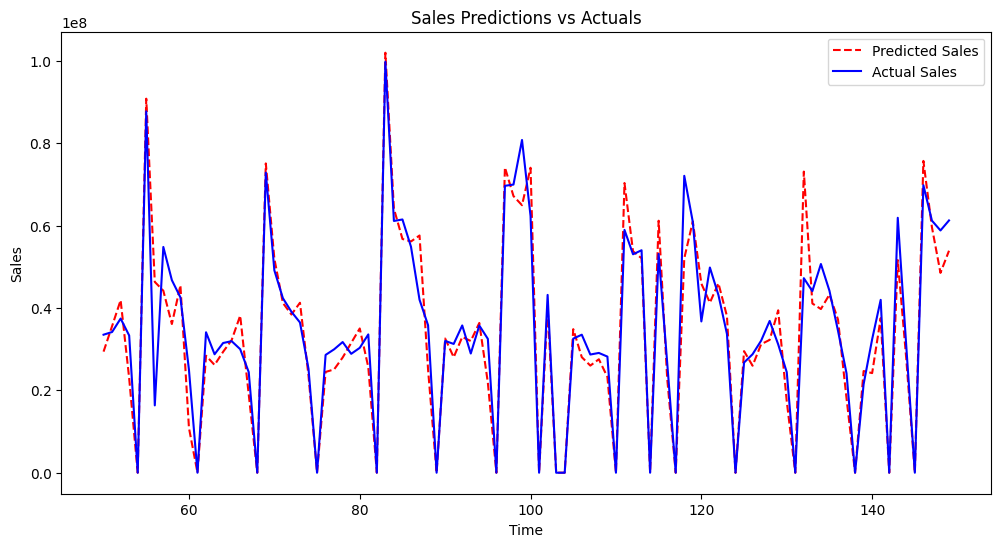

,Sales Predictions,Sales Actuals
50,2.941084e+07,33524100
51,3.560635e+07,34175716
52,4.190504e+07,37442161
53,2.294774e+07,33327529
54,6.816907e+03,0
...,...,...
145,3.569174e+03,0
146,7.573774e+07,69839449
147,5.964019e+07,61230625
148,4.854076e+07,58844241


In [11]:
plot_predictions_sales(xgb_model, X_test, y_test, start=50, end=150)